In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 1024,
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}

In [2]:
#A placeholder GPT model architecture class 

import torch 
import torch.nn as nn 

In [18]:
class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape,eps=1e-5): 
        super().__init__() 
    
    def forward(self,x): 
        return x # also not useful will will fix that later 

In [19]:
class DummyTransformerBlock(nn.Module): 
    def __init__(self,cfg:dict=GPT_CONFIG_124M):
        super().__init__() 
        self.cfg = cfg # :(
        
    def forward(self,x): 
        return x  # this block has nothing and just returns its input  

In [20]:
class DummpyGPTModel(nn.Module): 
    def __init__(self,cfg:dict=GPT_CONFIG_124M):
        super().__init__() 
        self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim']) 
        self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'],cfg['vocab_size'],bias=False
        )
    
    def forward(self,in_idx:torch.Tensor): 
        batch_size , seq_len = in_idx.shape 
        tok_embeds = self.tok_emb(in_idx) 
        pos_embeds = self.pos_emb(
            torch.arange(seq_len,device=in_idx.device)
        )
        x = tok_embeds + pos_embeds # B,T,C 
        x = self.drop_emb(x) 
        x  = self.trf_blocks(x) # B,T,C 
        x = self.final_norm(x) 
        logits = self.out_head(x) # B,T,vocab_size 
        return logits 


In [21]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [22]:
torch.manual_seed(123) 
model = DummpyGPTModel(GPT_CONFIG_124M) 


In [23]:
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [25]:
# normalizing activatins with layer normalization 

torch.manual_seed(123)
batch_example = torch.randn(2,5) 

layer = nn.Sequential(nn.Linear(5,6), nn.ReLU()) 

out  = layer(batch_example) 
print(out); print(out.shape)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
torch.Size([2, 6])


In [28]:
mean = torch.mean(out,dim=-1,keepdim=True) 
var = out.var(dim=-1,keepdim=True) 

print("Mean:\n",mean) 
print("Variance\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [29]:
out_norm = (out - mean) / torch.sqrt(var) 

mean = out_norm.mean(dim=-1,keepdim=True) 
var = out_norm.var(dim=-1,keepdim=True) 
print("Normalized layer outputs:\n",out_norm) 
print("Mean:\n",mean) 
print("Variance:\n",var) 

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [30]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [32]:
class LayerNorm(nn.Module): 
    def __init__(self,emb_dim): 
        super().__init__() 
        self.eps = 1e-5 
        self.scale = nn.Parameter(torch.ones(emb_dim)) 
        self.shift = nn.Parameter(torch.zeros(emb_dim)) 
    
    def forward(self,x): 
        mean = x.mean(dim=-1,keepdim=True) 
        var = x.var(dim=-1,keepdim=True,unbiased=False) 
        norm_x  = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift # we are not forcing them to be gausian , model 
        # can do what it whant here :) 


""" 
In our variance calculation method, we use an implemenation detail by setting 
unbiased=False, this mean , in the varaince calculation , we divide by the 
numer of inputs n in the variance formula. This approach does not apply bessels correction 
which typicaly uses n-1 instaed of n in the denominator to adjust for 
bias in sample varaince . For LLLMs , where the embedding dimenstin n is significantly 
large , the difference between n and n-1 is practically negligible.  i choose this approach 
to ensure compatibiltiy the the GPT-2 model normalization layer and becasue it refrect 
Tensorflows default behaviour which is used to implement the original GPT-2 model. 
"""

' \nIn our variance calculation method, we use an implemenation detail by setting \nunbiased=False, this mean , in the varaince calculation , we divide by the \nnumer of inputs n in the variance formula. This approach does not apply bessels correction \nwhich typicaly uses n-1 instaed of n in the denominator to adjust for \nbias in sample varaince . For LLLMs , where the embedding dimenstin n is significantly \nlarge , the difference between n and n-1 is practically negligible.  i choose this approach \nto ensure compatibiltiy the the GPT-2 model normalization layer and becasue it refrect \nTensorflows default behaviour which is used to implement the original GPT-2 model. \n'

In [33]:
ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example) 
mean = out_ln.mean(dim=-1,keepdim=True) 
var = out_ln.var(dim=-1,unbiased=False,keepdim=True) 
print("Mean:\n",mean) 
print("Variance:\n",var) 

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [34]:
""" 
if you are famiear with batch normalization, a common and traditional normalization
method for neural networks, you may wonder how it compares to layer normalization. Unlike 
batch normalization, which normalizes across the batch dimenstin, layer normalization 
normalizes across the feature dimenstin. LLMS often rquires significant comutational 
resources , and the available hardware or the specific use case can dictate the 
batch size durin training or inference, since layer normalization normalizes each 
input independently of the batch size, if offers more flexibility and stability 
in these scenarios. 
""" 
#---------------------------------------------------------------------------
# implementing a feed forward network with GELU activations 

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))

In [35]:
import matplotlib.pyplot as plt 

gelu, relu  = GELU(), nn.ReLU() 



In [36]:
x = torch.linspace(-3,3,100) 
y_gelu, y_relu  = gelu(x), relu(x) 



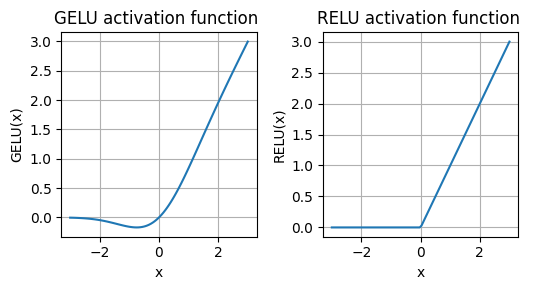

In [37]:
plt.figure(figsize=(8,3))

for i, (y,label) in enumerate(zip([y_gelu,y_relu],["GELU","RELU"]),1): 
    plt.subplot(1,3,i) 
    plt.plot(x,y) 
    plt.title(f"{label} activation function " ) 
    plt.xlabel("x") 
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout() 
plt.show()

In [40]:
class FeedForward(nn.Module): 
    def __init__(self,cfg:dict): 
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
            GELU(), 
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    
    def forward(self,x): 
        return self.layers(x) 


In [41]:
ffn = FeedForward(GPT_CONFIG_124M) 
x = torch.rand(2,3,768) 
out = ffn(x) 
print(out.shape)

torch.Size([2, 3, 768])


In [42]:
## adding shortcut connections 

class ExampleDeepNeuralNetwork(nn.Module): 
    def __init__(self,layer_sizes,use_shortcut): 
        super().__init__() 
        self.use_shortcut = use_shortcut  
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU())
        ]) 
    
    def forward(self,x): 
        for layer in self.layers: 
            layer_output = layer(x) 
            if self.use_shortcut and x.shape == layer_output.shape: 
                x = x + layer_output
            else: 
                x = layer_output 
        
        return x 

In [43]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [45]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [47]:
print_gradients(model_without_shortcut, sample_input) 
# we can see the gradient becoming smaller , this is gradient vanishing problem :(

layers.0.0.weight has gradient mean of 0.00040347169851884246
layers.1.0.weight has gradient mean of 0.00024022319121286273
layers.2.0.weight has gradient mean of 0.0014304080978035927
layers.3.0.weight has gradient mean of 0.002797747263684869
layers.4.0.weight has gradient mean of 0.010099290870130062


In [48]:
# lets now use skip connections 
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [49]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, D_in = x.shape

        Q = self.W_query(x)  # (B, T, D_out)
        K = self.W_key(x)    # (B, T, D_out)
        V = self.W_value(x)  # (B, T, D_out)


        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T, head_dim)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, num_heads, T, T)

        mask = self.mask[:T, :T].bool()
        attn_scores = attn_scores.masked_fill(mask[None, None, :, :], float('-inf'))

        # Softmax and dropout
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention
        context = attn_weights @ V  # (B, num_heads, T, head_dim)

        # Merge heads back
        context = context.transpose(1, 2).contiguous().view(B, T, self.d_out)
        context = self.out_proj(context)

        return context


In [50]:
class TransformerBlock(nn.Module): 
    def __init__(self,cfg:dict):
        super().__init__() 
        self.att = MultiHeadAttention(
            d_in= cfg['emb_dim'],
            d_out = cfg['emb_dim'], 
            context_length=cfg['context_length'], 
            num_heads = cfg['n_heads'], 
            dropout = cfg['drop_rate'], 
            qkv_bias=cfg['qkv_bias'] 
        )
        self.ff = FeedForward(cfg) 
        self.norm1 = LayerNorm(cfg['emb_dim']) 
        self.norm2 = LayerNorm(cfg['emb_dim']) 
        self.drop_shortcut = nn.Dropout(cfg['drop_rate']) 
    
    def forward(self,x): 
        shortcut = x 
        x = self.norm1(x) 
        x = self.att(x) 
        x = self.drop_shortcut(x) 
        x = x + shortcut 

        shortcut = x 
        x = self.norm2(x) 
        x = self.ff(x)  
        x = self.drop_shortcut(x) 
        x = x + shortcut 
        return x 


In [51]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape) 

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [56]:
class GPTModel(nn.Module): 
    def __init__(self,cfg:dict): 
        super().__init__() 
        self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim']) 
        self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim']) 
        self.drop_emb = nn.Dropout(cfg['drop_rate']) 

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim']) 

        self.out_head = nn.Linear( 
            cfg['emb_dim'], cfg['vocab_size'],bias=False
        )
    
    def forward(self,in_idx:torch.Tensor): 
        batch_size, sq_len =  in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)  
        pos_embeds = self.pos_emb(
            torch.arange(sq_len,device=in_idx.device)
        )
        x = tok_embeds + pos_embeds 
        x = self.drop_emb(x) 
        x = self.trf_blocks(x) 
        x = self.final_norm(x) 
        logits = self.out_head(x) 
        return logits 

In [57]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [58]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [59]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [60]:
total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [61]:
# memory required 
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [62]:
# generating text 
def generate_text_simple(model,idx,max_new_tokens,context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] 
        with torch.no_grad(): 
            logits = model(idx_cond) 
        logits = logits[:,-1,:]
        probas = torch.softmax(logits,dim=-1) 
        idx_next = torch.argmax(probas,dim=-1,keepdim=True) 
        idx = torch.cat((idx,idx_next),dim=1) 
    return idx   


In [63]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [64]:
model.eval() 

out = generate_text_simple(
    model = model  , 
    idx = encoded_tensor, 
    max_new_tokens=6, 
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output:",out) 
print("Output lenght",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output lenght 10


In [65]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
